3D regularization for a site-wise least-squares problem
==


Download escape data

In [1]:
!curl -so escape_data.csv -L "https://github.com/jbloomlab/SARS2_RBD_Ab_escape_maps/blob/main/processed_data/escape_data.csv?raw=true"

Download spike structure from PDB

In [2]:
!curl -sOL "https://files.rcsb.org/download/6M0J.pdb"

In [3]:
from mushi import optimization as opt
import jax.numpy as np
from jax import grad, jit, random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import Bio.PDB
import pandas as pd
import nglview as nv
import pdb_prot_align
import pdb_prot_align.colorschemes
import pdb_prot_align.nglview_struct
from scipy.spatial.distance import pdist, squareform

Get sitewise escape data for one antibody, and also create a noisy signal based on it

In [4]:
seed = 0
key = random.PRNGKey(seed)

/Users/williamdewitt/Applications/miniconda2/envs/penalties/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


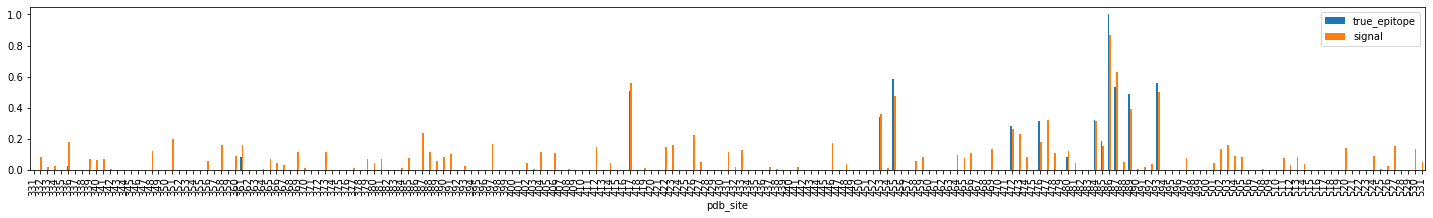

,pdb_site,true_epitope,pdb_chain,signal
0,331,0.0,E,0.000000
1,332,0.0,E,0.081589
2,333,0.0,E,0.016461
3,334,0.0,E,0.026143
4,335,0.0,E,0.000000
...,...,...,...,...
196,527,0.0,E,0.155724
197,528,0.0,E,0.000000
198,529,0.0,E,0.000000
199,530,0.0,E,0.131992


In [5]:
escape_df = pd.read_csv("escape_data.csv")
Ab = "REGN10933"
sites_df = escape_df.loc[escape_df.condition == Ab].groupby("site").site_total_escape.first().reset_index()
sites_df["pdb_chain"] = "E"
sites_df.rename(columns={"site": "pdb_site", "site_total_escape": "true_epitope"}, inplace=True)
sites_df["signal"] = np.clip(sites_df["true_epitope"].values + 0.1 * random.normal(key, (len(sites_df),)), 0)

sites_df.plot(x="pdb_site", y=["true_epitope", "signal"], kind="bar", figsize=(25, 3))
plt.show()

sites_df

Color map for protein viz of signal

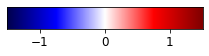

In [6]:
cmap = pdb_prot_align.colorschemes.ValueToColorMap(
                            minvalue=-1.5,
                            maxvalue=1.5,
                            cmap='seismic')

cmap.scale_bar(label=None, orientation='horizontal');

Register color schemes with nglview using Jesse's package

In [7]:
pdb_prot_align.nglview_struct.colorscheme_by_site(
                               'true_epitope',
                                sites_df=sites_df,
                                color_by=('true_epitope', cmap))

pdb_prot_align.nglview_struct.colorscheme_by_site(
                               'signal',
                                sites_df=sites_df,
                                color_by=('signal', cmap))

Display true epitope

In [8]:
view = nv.show_structure_file("6M0J.pdb", default_representation=False)
view.add_surface(selection="protein and :E", color="true_epitope")
view

NGLWidget()

Display noisy signal based on epitope

In [9]:
view2 = nv.show_structure_file("6M0J.pdb", default_representation=False)
view2.add_surface(selection="protein and :E", color="signal")
view2

NGLWidget()

Caelan's function for getting 3D coordinates CA atoms in each residue/site.

Note: when [PR #34](https://github.com/jbloomlab/polyclonal/pull/34) is merged, just import this function

In [10]:
def extract_atom_locations(
    input_pdbfile,
    target_chains,
    target_atom="CA",
):
    """Extract atom locations from target chains of a PDB file.
    By default the locations of alpha carbons are extracted, but any atom
    can be specified. If a residue does not have the specified atom,
    it is not included in the output file.
    Parameters
    ----------
    input_pdbfile : str
        Path to input PDB file.
    target_chains : list
        List of target chains to extract atom locations from. Chains must be in
        the PDB and match the chain ids.
    target_atom: str
        Which type of atom to extract locations for. Default is alpha carbon, or
        'CA'. If the specified type of atom is present multiple times for a
        residue, that residue will end up having multiple entries in the output.
    Returns
    -------
    pandas.DataFrame
        Has columns 'chain', 'site', 'x', 'y', and 'z'.
    Example
    -------
    Download PDB, do the re-assignment of B factors, read the lines
    from the resulting re-assigned PDB:
    >>> pdb_url = 'https://files.rcsb.org/download/6M0J.pdb'
    >>> r = requests.get(pdb_url)
    >>> with tempfile.TemporaryDirectory() as tmpdir:
    ...    pdbfile = os.path.join(tmpdir, '6M0J.pdb')
    ...    with open(pdbfile, 'wb') as f:
    ...        _ = f.write(r.content)
    ...    output = extract_atom_locations(pdbfile, ['A'])
    Check the first ten lines of the ouput to make sure we got the expected
    atom locations:
    >>> output.head(n=10)
      chain  site          x          y      z
    0     A    19 -31.358999  50.852001  2.040
    1     A    20 -29.424000  50.561001 -1.234
    2     A    21 -30.722000  48.633999 -4.234
    3     A    22 -28.080999  45.924999 -3.794
    4     A    23 -28.982000  45.372002 -0.131
    5     A    24 -32.637001  44.912998 -1.106
    6     A    25 -31.709999  42.499001 -3.889
    7     A    26 -29.688999  40.509998 -1.334
    8     A    27 -32.740002  40.337002  0.917
    9     A    28 -34.958000  39.424000 -2.028
    """

    # read PDB, catch warnings about discontinuous chains
    with warnings.catch_warnings():
        warnings.simplefilter(
            "ignore", category=Bio.PDB.PDBExceptions.PDBConstructionWarning
        )
        pdb = Bio.PDB.PDBParser().get_structure("_", input_pdbfile)

    # get the chains out of the PDB
    chains = list(pdb.get_chains())
    chain_ids = [chain.id for chain in chains]

    # make sure the target chains are in the PDB
    for chain in target_chains:
        if chain not in chain_ids:
            raise ValueError(f"{chain} not in {input_pdbfile}")

    # make a list of chains to extract atom locations from
    chains_to_use = []
    for i, chain in enumerate(chain_ids):
        if chain in target_chains:
            chains_to_use.append(chains[i])

    # extract atom locations from target chains
    chain_list = []
    residue_list = []
    x_list = []
    y_list = []
    z_list = []
    for chain in chains_to_use:
        for residue in chain.get_residues():
            residue_number = residue.get_id()[1]
            atoms = residue.get_atoms()
            for atom in atoms:
                if atom.get_id() == target_atom:
                    x, y, z = atom.get_coord()
                    x_list.append(x)
                    y_list.append(y)
                    z_list.append(z)
                    residue_list.append(residue_number)
                    chain_list.append(chain.id)

    # write output
    output = pd.DataFrame(
        {
            "chain": chain_list,
            "site": residue_list,
            "x": x_list,
            "y": y_list,
            "z": z_list,
        }
    )

    return output.reset_index(drop=True)


In [11]:
coords = extract_atom_locations("6M0J.pdb", "E").set_index("site").drop("chain", axis=1)
coords

,x,y,z
site,,,
333,-34.099998,15.480000,47.591999
334,-36.286999,15.087000,44.473999
335,-35.084000,14.305000,40.955002
336,-34.688000,17.165001,38.487999
337,-37.398998,16.812000,35.770000
...,...,...,...
522,-27.403999,26.365000,45.564999
523,-30.629000,24.422001,44.980000
524,-29.306000,22.125999,42.195000


Use a gaussian kernel to compute the Laplacian. Display the adjacency matrix (contact map) to assess the choice of kernel bandwidth

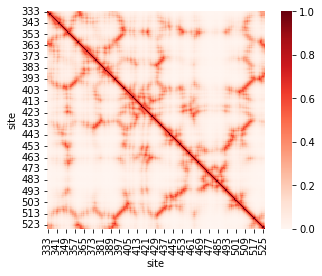

In [12]:
# bandwidth
σ = 3
# adjacency matrix
A = np.exp(-squareform(pdist(coords)) / σ ** 2)
# degree matrix
D = np.diag(A.sum(1))
# Laplacian matrix
L = D - A

sns.heatmap(
    pd.DataFrame(A, columns=coords.index, index=coords.index, dtype=float),
    cmap='Reds', vmin=0, square=True)
plt.show()

Available penalties (all can be used in any combination).
- `λ_lasso`: $\ell_1$ norm, inducing sparsity
- `λ_laplacian`: Laplacian smoothing
- `λ_moment`: 2nd moment of spatial distribution of parameters (wrt centroid).
- ~`λ_trend`: trend filtering, inducing piecewise polynomial solutions~ [need graph version of this]

In [60]:
λ_lasso = 1e-1
λ_laplacian = 1e-4
λ_moment = 1e-4
# λ_trend = 0

Run optimization to infer epitope from noisy signal

In [61]:
# trend_order = 3

# smooth out the singularity in centroid estimation
ϵ = 1e-3

# JAX DeviceArray of epitope signal, only for sites in coords
signal = np.array(sites_df.set_index("pdb_site").loc[coords.index].signal.values)

# JAX DeviceArray of spatial data
xyz = np.array(coords.values)

@jit
def g(θ):
    centroid = ((θ + ϵ)[:, None] * xyz).sum() / (θ + ϵ).sum()
    return ((signal - θ) ** 2).sum() + λ_laplacian * θ.T @ L @ θ + λ_moment * (θ[:, None] * (xyz - centroid) ** 2).sum()

grad_g = jit(grad(g))

@jit
def h1(θ):
    return  λ_lasso * np.linalg.norm(θ, 1)

@jit
def prox_h1(u, s):
    # note: outer clip is the bound constraint to non-negative orthant
    return np.clip(np.sign(u) * np.clip(np.abs(u) - s * λ_lasso, 0), 0)

# @jit
# def h2(θ):
#     return λ_trend * np.linalg.norm(np.diff(θ, trend_order), 1)

# # no jit due to prox-tv module
# def prox_h2(u, s):
#     if λ_trend:
#         trend_filterer = opt.TrendFilter((trend_order,), (s * λ_trend,))
#         x = trend_filterer.run(u)
#     else:
#         x = u
#     return np.clip(x, 0)


# optimizer = opt.ThreeOpProxGrad(g, grad_g, h1, prox_h1, h2, prox_h2, verbose=True)
optimizer = opt.AccProxGrad(g, grad_g, h1, prox_h1, verbose=True)

key, subkey = random.split(key)
θ = np.clip(random.normal(subkey, (len(xyz),)), 0)

θ = optimizer.run(θ, tol=0)

sites_df["inferred_epitope"] = 0
sites_df.loc[sites_df.pdb_site.isin(coords.index), "inferred_epitope"] = θ

initial objective 1.427900e+02
iteration 100, objective 2.353e+00, relative change 0.000e+00                                                                               
maximum iteration 100 reached with relative change in objective function 0


True Vs inferred sparsity 

In [63]:
sum(sites_df.true_epitope != 0), sum(sites_df.inferred_epitope != 0)

(14, 17)

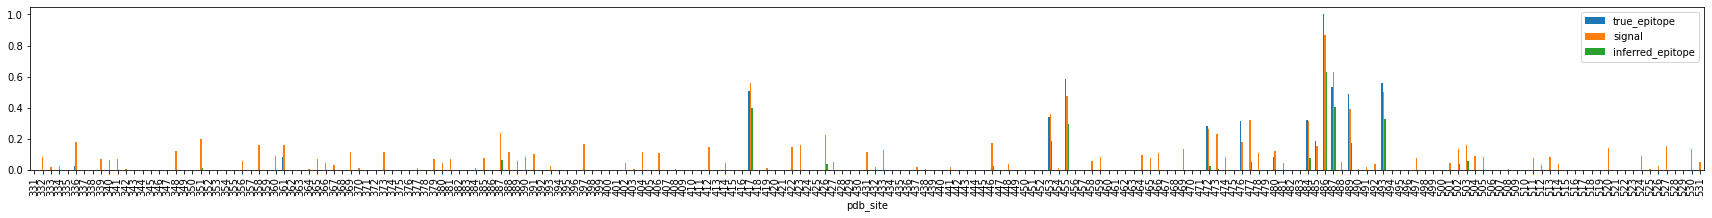

In [64]:
sites_df.plot(x="pdb_site", y=["true_epitope", "signal", "inferred_epitope"], kind="bar", figsize=(30, 3))
plt.show()

In [65]:
pdb_prot_align.nglview_struct.colorscheme_by_site(
                               'inferred_epitope',
                                sites_df=sites_df,
                                color_by=('inferred_epitope', cmap))

view3 = nv.show_structure_file("6M0J.pdb", default_representation=False)
view3.add_surface(selection="protein and :E", color="inferred_epitope")
view3

NGLWidget()

In [66]:
sites_df

,pdb_site,true_epitope,pdb_chain,signal,inferred_epitope
0,331,0.0,E,0.000000,0.0
1,332,0.0,E,0.081589,0.0
2,333,0.0,E,0.016461,0.0
3,334,0.0,E,0.026143,0.0
4,335,0.0,E,0.000000,0.0
...,...,...,...,...,...
196,527,0.0,E,0.155724,0.0
197,528,0.0,E,0.000000,0.0
198,529,0.0,E,0.000000,0.0
199,530,0.0,E,0.131992,0.0
